# Resale HDB Price Analytics


[Overall](#Overall)

[DBSS](#DBSS)

In [1]:
import os, sys
import re, json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from glob import glob

import matplotlib
matplotlib.style.use('ggplot')

%matplotlib inline
pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',2000)

from utils import *

In [2]:
latest_file = [x for x in glob('./output/*.xlsx') if '~' not in x][-1]
latest_file

'./output\\HDB_resale_prices_2020-10-14.xlsx'

In [3]:
hdb = pd.read_excel(latest_file)

In [4]:
hdb.head()

,Town,Room Type,Block,Street,Storey,Lease Commencement Date,Remaining Lease,Resale Registration Date,Price,Sqm,Town Code,Type
0,Ang Mo Kio,2,314,Ang Mo Kio Ave 3,10 to 12,1978,56 years,Oct 2020,"$220,000.00",44.0,AMK,Improved
1,Ang Mo Kio,2,508,Ang Mo Kio Ave 8,04 to 06,1980,58 years,Sep 2020,"$200,000.00",44.0,AMK,Improved
2,Ang Mo Kio,2,314,Ang Mo Kio Ave 3,04 to 06,1978,56 years,Jul 2020,"$198,000.00",44.0,AMK,Improved
3,Ang Mo Kio,2,314,Ang Mo Kio Ave 3,04 to 06,1978,56 years,Jul 2020,"$207,000.00",44.0,AMK,Improved
4,Ang Mo Kio,2,508,Ang Mo Kio Ave 8,01 to 03,1980,58 years,Jul 2020,"$208,000.00",44.0,AMK,Improved


In [5]:
hdb = preprocessHDBdf(hdb)

In [6]:
hdb.shape

(11631, 20)

In [7]:
hdb.columns

Index(['Town', 'Room Type', 'Block', 'Street', 'Storey',
       'Lease Commencement Date', 'Remaining Lease',
       'Resale Registration Date', 'Price', 'Sqm', 'Town Code', 'Type',
       'Remaining Lease (Year)', 'Remaining Lease (Month)',
       'Remaining Lease in Months', 'Sqft', 'Price per Sqm', 'Price per Sqft',
       'Price per Sqft per Remaining Lease year', 'Storey Range + Room Type'],
      dtype='object')

<a id='Overall'>Overall</a>

## Resale Volume

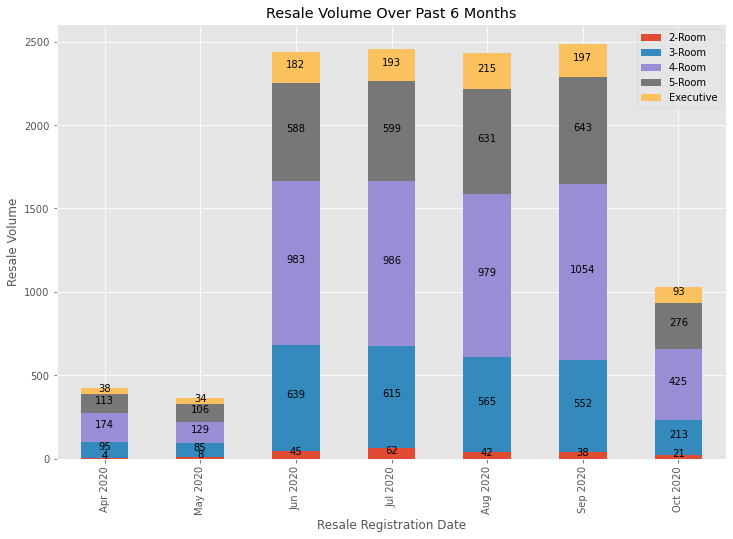

In [8]:
hdb_vol = hdb[hdb['Room Type'].isin(['2-Room','3-Room','4-Room','5-Room','Executive'])].\
groupby(['Resale Registration Date','Room Type']).agg({'Town':'count'}).unstack('Room Type').fillna(0).reset_index()
hdb_vol.columns = ['Resale Registration Date','2-Room','3-Room','4-Room','5-Room','Executive']
hdb_vol['Resale Registration Date'] =  pd.to_datetime(hdb_vol['Resale Registration Date'], format='%b %Y')
hdb_vol = hdb_vol.sort_values(by=['Resale Registration Date'], ascending=True)
hdb_vol['Resale Registration Date'] = hdb_vol['Resale Registration Date'].apply(lambda x: datetime.strftime(x, '%b %Y'))
hdb_vol.set_index(['Resale Registration Date'], inplace=True)
ax = hdb_vol.plot(kind='bar', stacked=True, figsize=(12,8), title='Resale Volume Over Past 6 Months')
ax.legend(bbox_to_anchor=(1, 1))
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0 and height < np.inf:
        ax.annotate(int(round(height)),\
                    (x+width/2, y+height/2),\
                    ha='center', va='center', xytext=(0, 3), textcoords='offset points')
ax.set_ylabel('Resale Volume')
plt.show()

## Total Resale Volume Over Past 6 months by Town

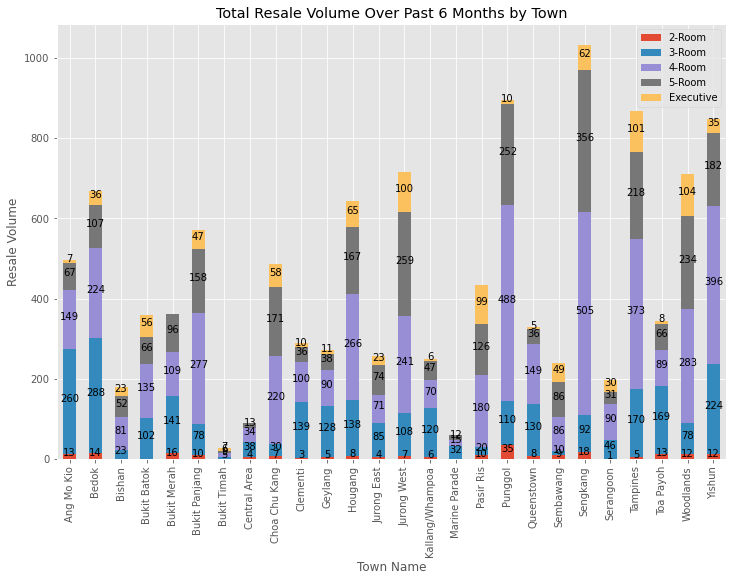

In [9]:
hdb_vol = hdb[hdb['Room Type'].isin(['2-Room','3-Room','4-Room','5-Room','Executive'])].\
groupby(['Town','Room Type']).agg({'Town':'count'}).unstack('Room Type').fillna(0).reset_index()

hdb_vol.columns = ['Town Name','2-Room','3-Room','4-Room','5-Room','Executive']
hdb_vol

ax = hdb_vol.plot(kind='bar', stacked=True, figsize=(12,8), x='Town Name', title='Total Resale Volume Over Past 6 Months by Town')
ax.legend(bbox_to_anchor=(1, 1))
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0 and height < np.inf:
        ax.annotate(int(round(height)),\
                    (x+width/2, y+height/2),\
                    ha='center', va='center', xytext=(0, 3), textcoords='offset points')
ax.set_ylabel('Resale Volume')
plt.show()

## Price Distribution

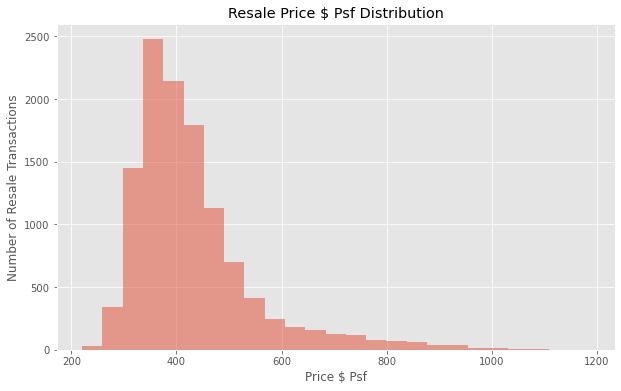

In [10]:
ax = hdb['Price per Sqft'].plot.hist(bins=25, alpha=0.5, figsize=(10,6), title='Resale Price $ Psf Distribution')
ax.set_xlabel('Price $ Psf')
ax.set_ylabel('Number of Resale Transactions')
plt.show()

(0.0, 11631.0)

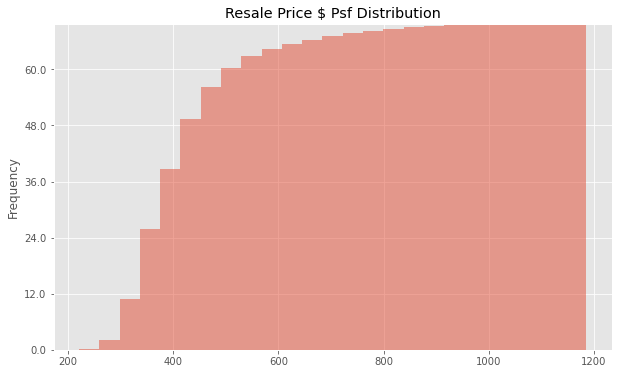

In [11]:
ax1 = hdb['Price per Sqft'].plot.hist(bins=25, alpha=0.5, figsize=(10,6), title='Resale Price $ Psf Distribution', cumulative = True)
ax1.set_yticklabels(np.arange(0,(hdb.shape[0]+1)/hdb.shape[0]*100, round(1/8*100)))
ax1.set_ylim(0,hdb.shape[0])

## Top 5 Most Expensive Resale HDBs by Room Type

In [12]:
hdb['Price rank room type'] = hdb.groupby('Room Type')['Price'].rank(ascending=False)

hdb[(hdb['Price rank room type']<=5)&(hdb['Room Type'].isin(['4-Room','5-Room','Executive','Multi-Generation']))].\
sort_values(['Room Type','Town'])

,Town,Room Type,Block,Street,Storey,Lease Commencement Date,Remaining Lease,Resale Registration Date,Price,Sqm,Town Code,Type,Remaining Lease (Year),Remaining Lease (Month),Remaining Lease in Months,Sqft,Price per Sqm,Price per Sqft,Price per Sqft per Remaining Lease year,Storey Range + Room Type,Price rank room type
1923,Bukit Merah,4-Room,43,Moh Guan Ter,04 to 06,1973,51 years,Aug 2020,1088000.0,131.0,BM,Adjoined,51,0,612,1410.084,8305.343511,771.585239,15.129122,04 to 06 4-Room,3.0
2727,Central Area,4-Room,1D,Cantonment Rd,49 to 51,2011,89 years,Jul 2020,1085000.0,94.0,CT,Type,89,0,1068,1011.816,11542.553191,1072.329356,12.048644,49 to 51 4-Room,4.0
2736,Central Area,4-Room,1B,Cantonment Rd,40 to 42,2011,89 years,Jun 2020,1186888.0,93.0,CT,Type,89,0,1068,1001.052,12762.236559,1185.640706,13.321806,40 to 42 4-Room,1.0
2710,Central Area,4-Room,1G,Cantonment Rd,43 to 45,2011,89 years,Oct 2020,1070000.0,93.0,CT,Type,89,0,1068,1001.052,11505.376344,1068.875543,12.009838,43 to 45 4-Room,5.0
2714,Central Area,4-Room,1C,Cantonment Rd,37 to 39,2011,89 years,Sep 2020,1100000.0,95.0,CT,Type,89,0,1068,1022.580,11578.947368,1075.710458,12.086634,37 to 39 4-Room,2.0
1273,Bishan,5-Room,275A,Bishan St 24,28 to 30,2011,89 years,Oct 2020,1208000.0,120.0,BH,Dbss,89,0,1068,1291.680,10066.666667,935.216153,10.508047,28 to 30 5-Room,2.5
2750,Central Area,5-Room,1A,Cantonment Rd,31 to 33,2011,89 years,Aug 2020,1185000.0,107.0,CT,Type,89,0,1068,1151.748,11074.766355,1028.870899,11.560347,31 to 33 5-Room,4.0
2745,Central Area,5-Room,1A,Cantonment Rd,40 to 42,2011,89 years,Sep 2020,1208000.0,106.0,CT,Type,89,0,1068,1140.984,11396.226415,1058.735267,11.895902,40 to 42 5-Room,2.5
2746,Central Area,5-Room,1B,Cantonment Rd,43 to 45,2011,89 years,Sep 2020,1258000.0,107.0,CT,Type,89,0,1068,1151.748,11757.009346,1092.252819,12.272504,43 to 45 5-Room,1.0
7349,Queenstown,5-Room,18C,Holland Dr,19 to 21,2012,91 years,Sep 2020,1158000.0,117.0,QT,Improved,91,0,1092,1259.388,9897.435897,919.494231,10.104332,19 to 21 5-Room,5.0


## Top 5 Least Expensive Resale HDBs by Room Type

In [13]:
hdb['Price rank room type (descending)'] = hdb.groupby('Room Type')['Price'].rank(ascending=True)
hdb[(hdb['Price rank room type (descending)']<=5)&(hdb['Room Type'].isin(['4-Room','5-Room','Executive','Multi-Generation']))].\
sort_values(['Room Type','Town'])

,Town,Room Type,Block,Street,Storey,Lease Commencement Date,Remaining Lease,Resale Registration Date,Price,Sqm,Town Code,Type,Remaining Lease (Year),Remaining Lease (Month),Remaining Lease in Months,Sqft,Price per Sqm,Price per Sqft,Price per Sqft per Remaining Lease year,Storey Range + Room Type,Price rank room type,Price rank room type (descending)
10426,Woodlands,4-Room,27,Marsiling Dr,01 to 03,1977,56 years,Apr 2020,240000.0,91.0,WL,New,56,0,672,979.524,2637.362637,245.016967,4.375303,01 to 03 4-Room,4730.0,1.0
10231,Woodlands,4-Room,7,Marsiling Dr,01 to 03,1976,54 years,Aug 2020,248000.0,88.0,WL,Improved,54,0,648,947.232,2818.181818,261.815479,4.848435,01 to 03 4-Room,4729.0,2.0
10232,Woodlands,4-Room,23,Marsiling Dr,01 to 03,1977,56 years,Aug 2020,256000.0,92.0,WL,New,56,0,672,990.288,2782.608696,258.510655,4.616262,01 to 03 4-Room,4727.0,4.0
10359,Woodlands,4-Room,5,Marsiling Dr,16 to 18,1974,53 years,Jun 2020,252000.0,90.0,WL,Improved,53,0,636,968.760,2800.000000,260.126347,4.908044,16 to 18 4-Room,4728.0,3.0
4654,Jurong East,5-Room,404,Pandan Gdns,04 to 06,1979,57 years,Jul 2020,310000.0,104.0,JE,Standard,57,0,684,1119.456,2980.769231,276.920218,4.858249,04 to 06 5-Room,2953.0,4.0
4665,Jurong East,5-Room,403,Pandan Gdns,07 to 09,1979,58 years,Jun 2020,300000.0,114.0,JE,Standard,58,0,696,1227.096,2631.578947,244.479650,4.215166,07 to 09 5-Room,2954.0,3.0
4666,Jurong East,5-Room,403,Pandan Gdns,04 to 06,1979,58 years,Jun 2020,318000.0,104.0,JE,Standard,58,0,696,1119.456,3057.692308,284.066547,4.897699,04 to 06 5-Room,2952.0,5.0
10667,Woodlands,5-Room,35,Marsiling Dr,13 to 15,1977,56 years,Apr 2020,280000.0,118.0,WL,Standard,56,0,672,1270.152,2372.881356,220.446057,3.936537,13 to 15 5-Room,2956.0,1.0
10666,Woodlands,5-Room,9,Marsiling Dr,04 to 06,1976,54 years,Apr 2020,285000.0,120.0,WL,Standard,54,0,648,1291.680,2375.000000,220.642884,4.085979,04 to 06 5-Room,2955.0,2.0
5357,Jurong West,Executive,274B,Jurong West St 25,01 to 03,2002,80 years,Aug 2020,400000.0,126.0,JW,Apartment,80,0,960,1356.264,3174.603175,294.927831,3.686598,01 to 03 Executive,952.0,1.0


## Top 5 Most Expensive Resale HDBs by PSF by Room Type

In [14]:
hdb['Price per Sqft Rank'] = hdb.groupby('Room Type')['Price'].rank(ascending=False)

hdb[(hdb['Price per Sqft Rank']<=5)&(hdb['Room Type'].isin(['4-Room','5-Room','Executive','Multi-Generation']))].\
sort_values(['Room Type','Town'])

,Town,Room Type,Block,Street,Storey,Lease Commencement Date,Remaining Lease,Resale Registration Date,Price,Sqm,Town Code,Type,Remaining Lease (Year),Remaining Lease (Month),Remaining Lease in Months,Sqft,Price per Sqm,Price per Sqft,Price per Sqft per Remaining Lease year,Storey Range + Room Type,Price rank room type,Price rank room type (descending),Price per Sqft Rank
1923,Bukit Merah,4-Room,43,Moh Guan Ter,04 to 06,1973,51 years,Aug 2020,1088000.0,131.0,BM,Adjoined,51,0,612,1410.084,8305.343511,771.585239,15.129122,04 to 06 4-Room,3.0,4728.0,3.0
2727,Central Area,4-Room,1D,Cantonment Rd,49 to 51,2011,89 years,Jul 2020,1085000.0,94.0,CT,Type,89,0,1068,1011.816,11542.553191,1072.329356,12.048644,49 to 51 4-Room,4.0,4727.0,4.0
2736,Central Area,4-Room,1B,Cantonment Rd,40 to 42,2011,89 years,Jun 2020,1186888.0,93.0,CT,Type,89,0,1068,1001.052,12762.236559,1185.640706,13.321806,40 to 42 4-Room,1.0,4730.0,1.0
2710,Central Area,4-Room,1G,Cantonment Rd,43 to 45,2011,89 years,Oct 2020,1070000.0,93.0,CT,Type,89,0,1068,1001.052,11505.376344,1068.875543,12.009838,43 to 45 4-Room,5.0,4726.0,5.0
2714,Central Area,4-Room,1C,Cantonment Rd,37 to 39,2011,89 years,Sep 2020,1100000.0,95.0,CT,Type,89,0,1068,1022.580,11578.947368,1075.710458,12.086634,37 to 39 4-Room,2.0,4729.0,2.0
1273,Bishan,5-Room,275A,Bishan St 24,28 to 30,2011,89 years,Oct 2020,1208000.0,120.0,BH,Dbss,89,0,1068,1291.680,10066.666667,935.216153,10.508047,28 to 30 5-Room,2.5,2954.5,2.5
2750,Central Area,5-Room,1A,Cantonment Rd,31 to 33,2011,89 years,Aug 2020,1185000.0,107.0,CT,Type,89,0,1068,1151.748,11074.766355,1028.870899,11.560347,31 to 33 5-Room,4.0,2953.0,4.0
2745,Central Area,5-Room,1A,Cantonment Rd,40 to 42,2011,89 years,Sep 2020,1208000.0,106.0,CT,Type,89,0,1068,1140.984,11396.226415,1058.735267,11.895902,40 to 42 5-Room,2.5,2954.5,2.5
2746,Central Area,5-Room,1B,Cantonment Rd,43 to 45,2011,89 years,Sep 2020,1258000.0,107.0,CT,Type,89,0,1068,1151.748,11757.009346,1092.252819,12.272504,43 to 45 5-Room,1.0,2956.0,1.0
7349,Queenstown,5-Room,18C,Holland Dr,19 to 21,2012,91 years,Sep 2020,1158000.0,117.0,QT,Improved,91,0,1092,1259.388,9897.435897,919.494231,10.104332,19 to 21 5-Room,5.0,2952.0,5.0


## Top 5 Least Expensive Resale HDBs by PSF by Room Type

In [15]:
hdb['Price per Sqft Rank (Descending)'] = hdb.groupby('Room Type')['Price'].rank(ascending=True)

hdb[(hdb['Price per Sqft Rank (Descending)']<=5)&(hdb['Room Type'].isin(['4-Room','5-Room','Executive','Multi-Generation']))].\
sort_values(['Room Type','Town'])

,Town,Room Type,Block,Street,Storey,Lease Commencement Date,Remaining Lease,Resale Registration Date,Price,Sqm,Town Code,Type,Remaining Lease (Year),Remaining Lease (Month),Remaining Lease in Months,Sqft,Price per Sqm,Price per Sqft,Price per Sqft per Remaining Lease year,Storey Range + Room Type,Price rank room type,Price rank room type (descending),Price per Sqft Rank,Price per Sqft Rank (Descending)
10426,Woodlands,4-Room,27,Marsiling Dr,01 to 03,1977,56 years,Apr 2020,240000.0,91.0,WL,New,56,0,672,979.524,2637.362637,245.016967,4.375303,01 to 03 4-Room,4730.0,1.0,4730.0,1.0
10231,Woodlands,4-Room,7,Marsiling Dr,01 to 03,1976,54 years,Aug 2020,248000.0,88.0,WL,Improved,54,0,648,947.232,2818.181818,261.815479,4.848435,01 to 03 4-Room,4729.0,2.0,4729.0,2.0
10232,Woodlands,4-Room,23,Marsiling Dr,01 to 03,1977,56 years,Aug 2020,256000.0,92.0,WL,New,56,0,672,990.288,2782.608696,258.510655,4.616262,01 to 03 4-Room,4727.0,4.0,4727.0,4.0
10359,Woodlands,4-Room,5,Marsiling Dr,16 to 18,1974,53 years,Jun 2020,252000.0,90.0,WL,Improved,53,0,636,968.760,2800.000000,260.126347,4.908044,16 to 18 4-Room,4728.0,3.0,4728.0,3.0
4654,Jurong East,5-Room,404,Pandan Gdns,04 to 06,1979,57 years,Jul 2020,310000.0,104.0,JE,Standard,57,0,684,1119.456,2980.769231,276.920218,4.858249,04 to 06 5-Room,2953.0,4.0,2953.0,4.0
4665,Jurong East,5-Room,403,Pandan Gdns,07 to 09,1979,58 years,Jun 2020,300000.0,114.0,JE,Standard,58,0,696,1227.096,2631.578947,244.479650,4.215166,07 to 09 5-Room,2954.0,3.0,2954.0,3.0
4666,Jurong East,5-Room,403,Pandan Gdns,04 to 06,1979,58 years,Jun 2020,318000.0,104.0,JE,Standard,58,0,696,1119.456,3057.692308,284.066547,4.897699,04 to 06 5-Room,2952.0,5.0,2952.0,5.0
10667,Woodlands,5-Room,35,Marsiling Dr,13 to 15,1977,56 years,Apr 2020,280000.0,118.0,WL,Standard,56,0,672,1270.152,2372.881356,220.446057,3.936537,13 to 15 5-Room,2956.0,1.0,2956.0,1.0
10666,Woodlands,5-Room,9,Marsiling Dr,04 to 06,1976,54 years,Apr 2020,285000.0,120.0,WL,Standard,54,0,648,1291.680,2375.000000,220.642884,4.085979,04 to 06 5-Room,2955.0,2.0,2955.0,2.0
5357,Jurong West,Executive,274B,Jurong West St 25,01 to 03,2002,80 years,Aug 2020,400000.0,126.0,JW,Apartment,80,0,960,1356.264,3174.603175,294.927831,3.686598,01 to 03 Executive,952.0,1.0,952.0,1.0


## HDB Median Prices and Volume

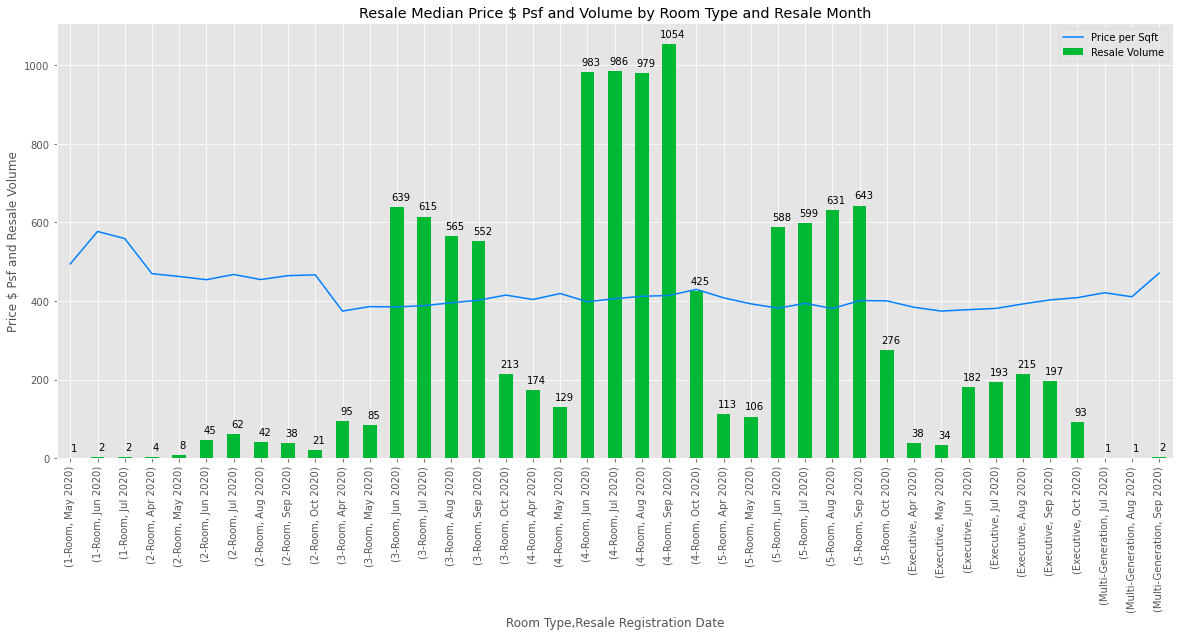

In [16]:
hdb_median_prices_bytime = hdb.groupby(['Room Type','Resale Registration Date']).agg({'Price per Sqft':'median'}).reset_index()
hdb_median_prices_bytime['Resale Registration Date'] =  pd.to_datetime(hdb_median_prices_bytime['Resale Registration Date'], format='%b %Y')
hdb_median_prices_bytime = hdb_median_prices_bytime.sort_values(by=['Room Type','Resale Registration Date'], ascending=True)
hdb_median_prices_bytime['Resale Registration Date'] = hdb_median_prices_bytime['Resale Registration Date'].apply(lambda x: datetime.strftime(x, '%b %Y'))
hdb_median_prices_bytime.set_index(['Room Type','Resale Registration Date'], inplace=True)

hdb_vol_bytime = hdb.groupby(['Room Type','Resale Registration Date']).agg({'Town':'count'}).reset_index()
hdb_vol_bytime.columns = ['Room Type','Resale Registration Date','Resale Volume']
hdb_vol_bytime['Resale Registration Date'] =  pd.to_datetime(hdb_vol_bytime['Resale Registration Date'], format='%b %Y')
hdb_vol_bytime = hdb_vol_bytime.sort_values(by=['Room Type','Resale Registration Date'], ascending=True)
hdb_vol_bytime['Resale Registration Date'] = hdb_vol_bytime['Resale Registration Date'].apply(lambda x: datetime.strftime(x, '%b %Y'))
hdb_vol_bytime.set_index(['Room Type','Resale Registration Date'], inplace=True)


ax = hdb_median_prices_bytime.plot(kind='line', figsize=(20,8), color = '#0080FF')
ax1 = hdb_vol_bytime.plot(kind='bar', figsize=(20,8), color = '#00b834', ax = ax)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0 and height < np.inf:
        ax.annotate(int(round(height)),\
                    (x+width, y+height),\
                    ha='center', va='center', xytext=(-3, 10), textcoords='offset points')
ax.set_title('Resale Median Price $ Psf and Volume by Room Type and Resale Month')
ax.set_ylabel('Price $ Psf and Resale Volume')
plt.show()

## Price (Median) per Sqft by Town and Room Type

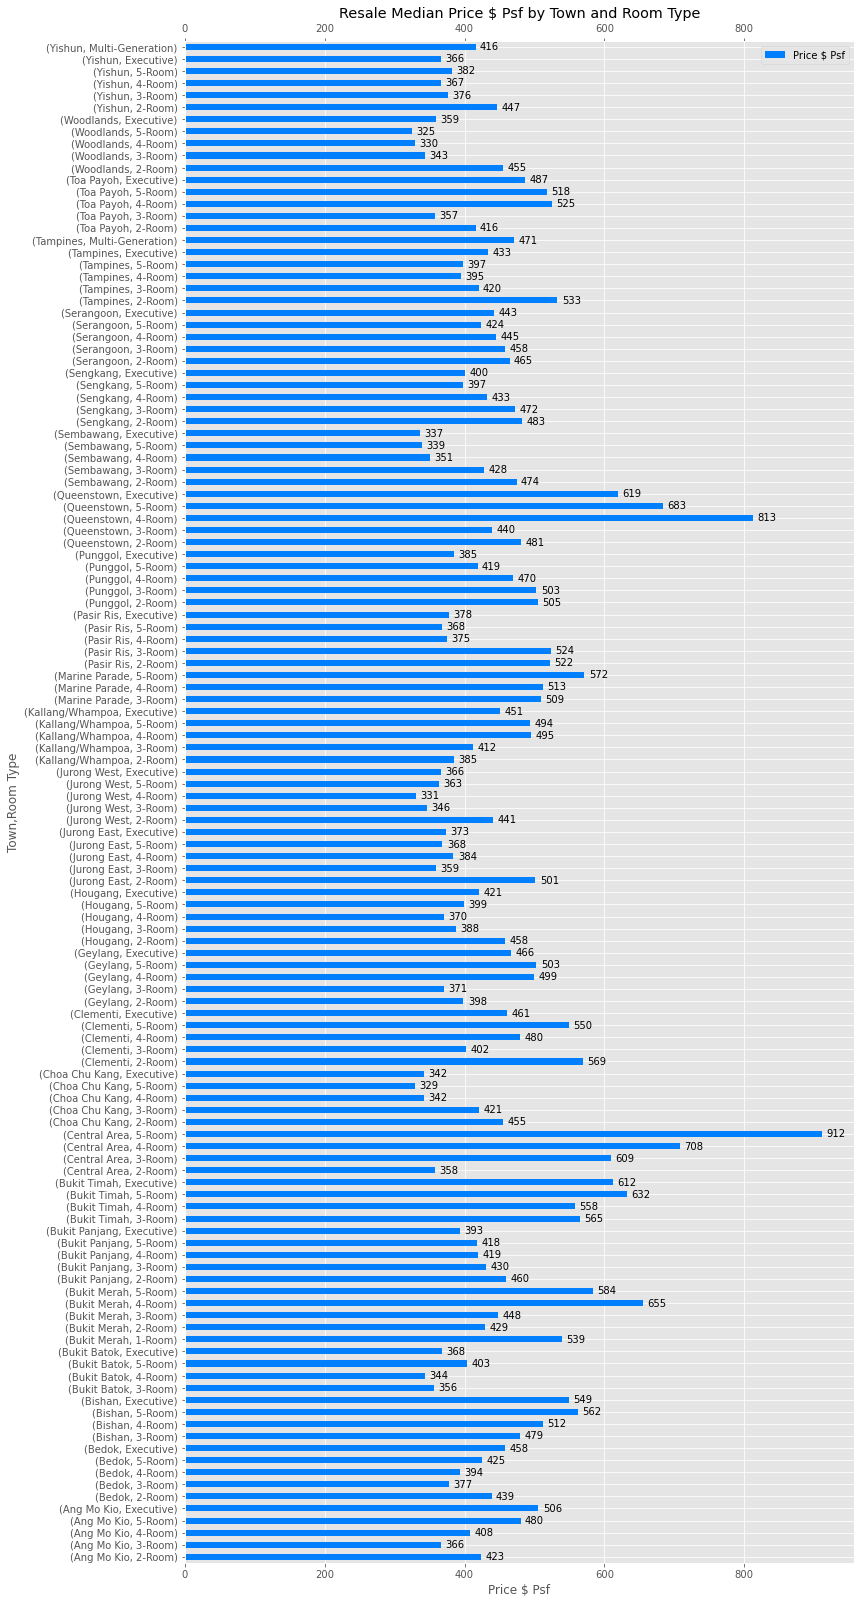

In [17]:
hdb_median_prices = hdb.groupby(['Town','Room Type']).agg({'Price per Sqft':'median'})
ax = hdb_median_prices.plot(kind = 'barh', figsize=(12,28), color='#0080FF')
# plt.suptitle(f"Median Price psf by Town", fontsize=18)
ax.set_xlabel("Price $ Psf", fontsize=12)
ax.set_title(f'Resale Median Price $ Psf by Town and Room Type')
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if width > 0 and width < np.inf:
        ax.annotate(int(round(width)),\
                    (x+width+20, y),\
                    ha='center', va='center', xytext=(0, 3), textcoords='offset points')

ax.legend(['Price $ Psf'])
plt.show()

## Price (Median) per Sqft by Town and Room Type per Remaining Lease Year

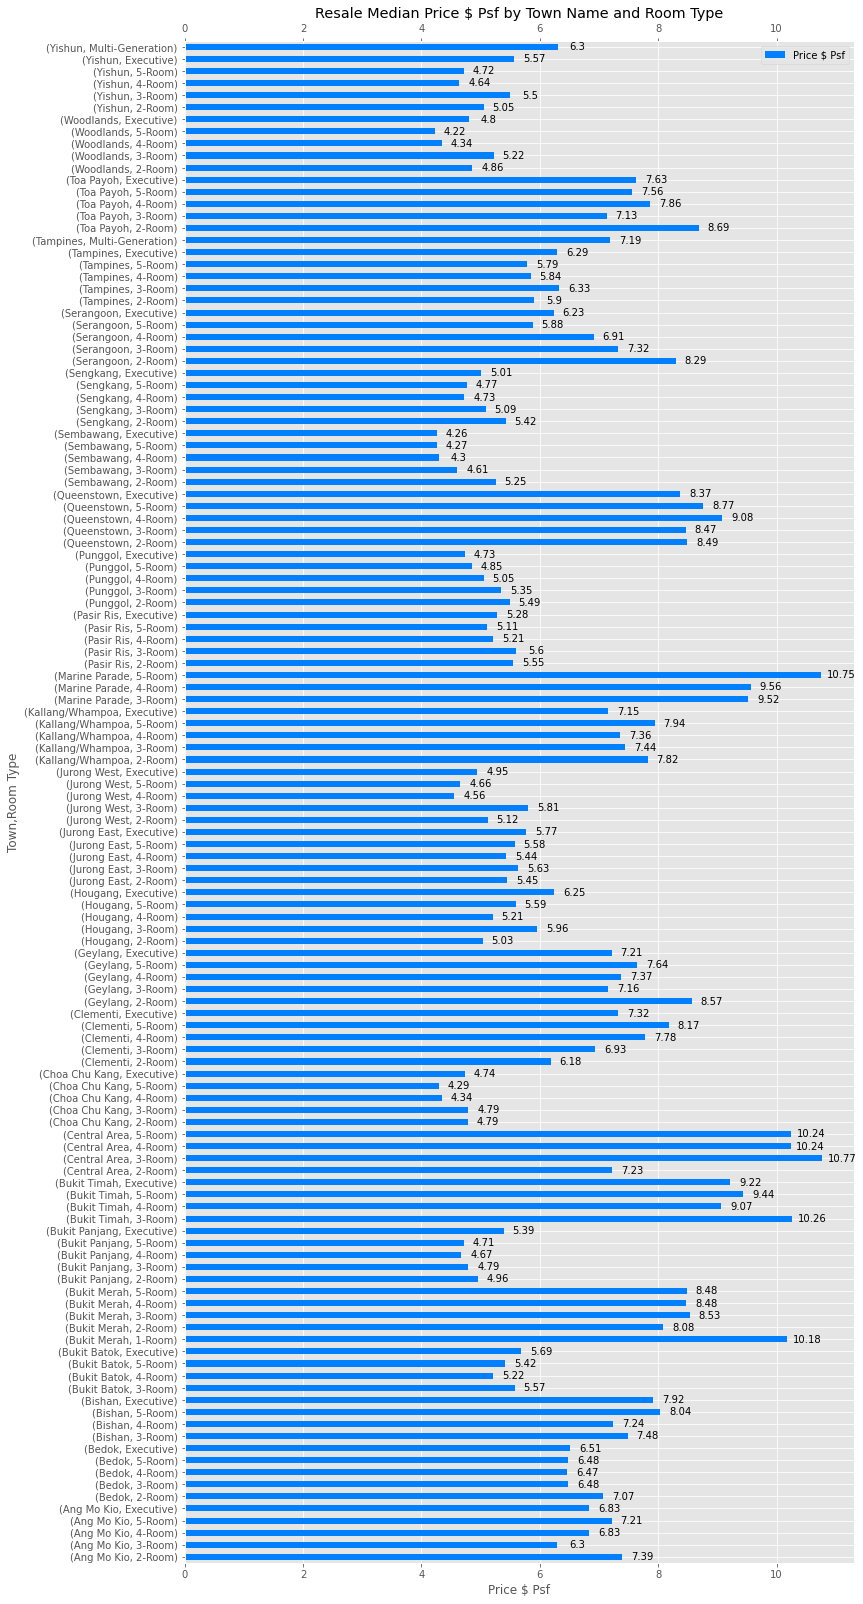

In [18]:
hdb_median_prices_remaining_lease = hdb.groupby(['Town','Room Type']).agg({'Price per Sqft per Remaining Lease year':'median'})
ax = hdb_median_prices_remaining_lease.plot(kind = 'barh', figsize=(12,28), color='#0080FF')
# plt.suptitle(f"Median Price psf by Town", fontsize=18)
ax.set_xlabel("Price $ Psf", fontsize=12)
ax.set_title(f'Resale Median Price $ Psf by Town Name and Room Type')
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
ax.legend(['Price $ Psf'])
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if width > 0 and width < np.inf:
        ax.annotate(round(width,2),\
                    (x+width, y),\
                    ha='center', va='center', xytext=(20, 3), textcoords='offset points')

plt.show()

## Remaining Lease Year by Town

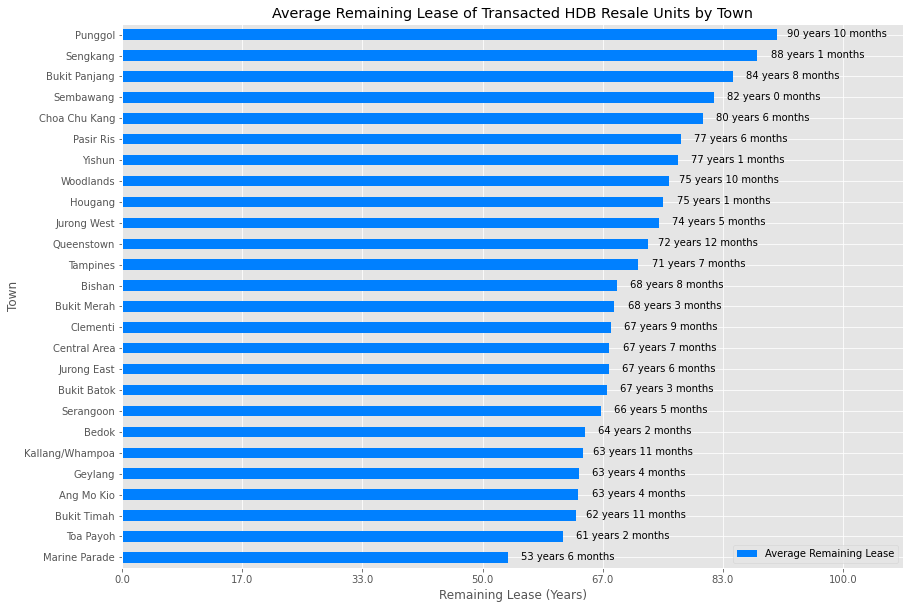

In [19]:
remaining_lease = hdb.groupby('Town').agg({'Remaining Lease in Months':'mean'}).reset_index()
remaining_lease['Remaining Lease in Years'] = remaining_lease['Remaining Lease in Months']//12
remaining_lease['Remaining Lease in (Months)'] = round(remaining_lease['Remaining Lease in Months']%12)
remaining_lease['Remaining Lease'] = remaining_lease['Remaining Lease in Years'].\
astype(int).astype(str) + ' years ' + remaining_lease['Remaining Lease in (Months)'].astype(int).astype(str) + ' months'
remaining_lease = remaining_lease.sort_values(by = 'Remaining Lease in Months')
ax = remaining_lease.plot(kind = 'barh', figsize=(14,10), color='#0080FF', x='Town', y='Remaining Lease in Months')
ax.set_xticklabels(np.round(np.arange(0,101,100/6)))
ax.legend(['Average Remaining Lease'])
ax.set_xlabel('Remaining Lease (Years)')
ax.set_xlim(0,1300)
cnt = 0
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if width > 0 and width < np.inf:
        ax.annotate(remaining_lease['Remaining Lease'].iloc[cnt],\
                    (x+width+100, y+height-0.7),\
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    cnt+=1

ax.set_title(f'Average Remaining Lease of Transacted HDB Resale Units by Town')

plt.show()

## Psft of HDBs with Lease < 60 years by Town and Room Type

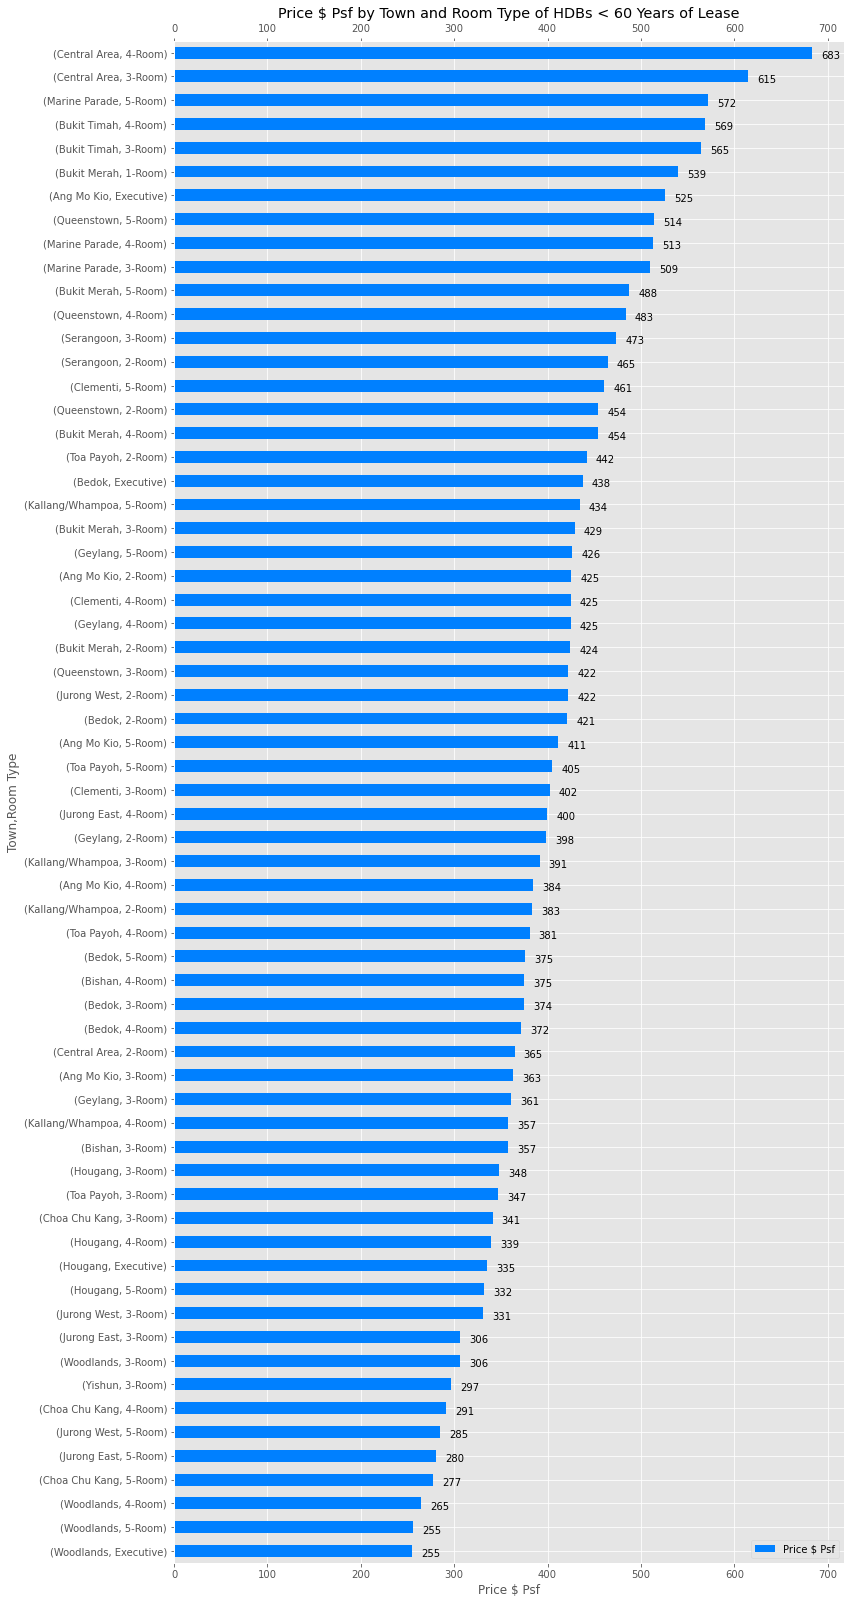

In [34]:
n=60
hdb_median_prices = hdb[hdb['Remaining Lease (Year)']<n].groupby(['Town','Room Type']).agg({'Price per Sqft':'median'}).\
sort_values(by='Price per Sqft')
ax = hdb_median_prices.plot(kind = 'barh', figsize=(12,28), color='#0080FF')
# plt.suptitle(f"Median Price psf by Town", fontsize=18)
ax.set_xlabel("Price $ Psf", fontsize=12)
ax.set_title(f'Price $ Psf by Town and Room Type of HDBs < {n} Years of Lease')
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if width > 0 and width < np.inf:
        ax.annotate(int(round(width)),\
                    (x+width+20, y),\
                    ha='center', va='center', xytext=(0, 3), textcoords='offset points')

ax.legend(['Price $ Psf'])
plt.show()

## Filter Resale hdb base on psft per remaining lease year

In [40]:
hdb.columns

Index(['Town', 'Room Type', 'Block', 'Street', 'Storey',
       'Lease Commencement Date', 'Remaining Lease',
       'Resale Registration Date', 'Price', 'Sqm', 'Town Code', 'Type',
       'Remaining Lease (Year)', 'Remaining Lease (Month)',
       'Remaining Lease in Months', 'Sqft', 'Price per Sqm', 'Price per Sqft',
       'Price per Sqft per Remaining Lease year', 'Storey Range + Room Type',
       'Price rank room type', 'Price rank room type (descending)',
       'Price per Sqft Rank', 'Price per Sqft Rank (Descending)'],
      dtype='object')

In [43]:
v = 728.33/(99-(2020-1998))
v

9.45883116883117

In [56]:
result = hdb[(hdb['Price per Sqft per Remaining Lease year']>=v-0.5)&\
            ~(hdb['Room Type'].isin(['1-Room','2-Room','3-Room']))&(hdb.Sqm>100)]
print(result.shape)
result.sort_values(by=['Town','Room Type','Price per Sqft per Remaining Lease year'])

(129, 24)


,Town,Room Type,Block,Street,Storey,Lease Commencement Date,Remaining Lease,Resale Registration Date,Price,Sqm,Town Code,Type,Remaining Lease (Year),Remaining Lease (Month),Remaining Lease in Months,Sqft,Price per Sqm,Price per Sqft,Price per Sqft per Remaining Lease year,Storey Range + Room Type,Price rank room type,Price rank room type (descending),Price per Sqft Rank,Price per Sqft Rank (Descending)
433,Ang Mo Kio,5-Room,710,Ang Mo Kio Ave 8,19 to 21,1980,59 years,Sep 2020,680000.0,117.0,AMK,Improved,59,0,708,1259.388,5811.965812,539.944799,9.151607,19 to 21 5-Room,413.5,2543.5,413.5,2543.5
495,Ang Mo Kio,Executive,608,Ang Mo Kio Ave 5,04 to 06,1980,59 years,May 2020,1030000.0,178.0,AMK,Adjoined,59,0,708,1915.992,5786.516854,537.580533,9.111534,04 to 06 Executive,5.0,948.0,5.0,948.0
1076,Bedok,5-Room,34,Chai Chee Ave,13 to 15,1975,53 years,Aug 2020,595000.0,114.0,BD,Standard,53,0,636,1227.096,5219.298246,484.884638,9.148767,13 to 15 5-Room,714.0,2243.0,714.0,2243.0
1051,Bedok,5-Room,19,Bedok Sth Rd,22 to 24,1976,54 years,Sep 2020,630000.0,114.0,BD,Standard,54,0,648,1227.096,5526.315789,513.407264,9.507542,22 to 24 5-Room,581.0,2376.0,581.0,2376.0
1231,Bishan,4-Room,503,Bishan St 11,04 to 06,1989,68 years,Jul 2020,680000.0,103.0,BH,Model,68,0,816,1108.692,6601.941748,613.335354,9.019638,04 to 06 4-Room,321.0,4410.0,321.0,4410.0
1270,Bishan,5-Room,128,Bishan St 12,13 to 15,1987,65 years,Oct 2020,760000.0,121.0,BH,Improved,65,0,780,1302.444,6280.991736,583.518370,8.977206,13 to 15 5-Room,250.0,2707.0,250.0,2707.0
1308,Bishan,5-Room,273B,Bishan St 24,13 to 15,2011,90 years,Jul 2020,1050000.0,120.0,BH,Dbss,90,0,1080,1291.680,8750.000000,812.894835,9.032165,13 to 15 5-Room,18.0,2939.0,18.0,2939.0
1309,Bishan,5-Room,275A,Bishan St 24,28 to 30,2011,90 years,Jul 2020,1060000.0,120.0,BH,Dbss,90,0,1080,1291.680,8833.333333,820.636690,9.118185,28 to 30 5-Room,16.0,2941.0,16.0,2941.0
1291,Bishan,5-Room,194,Bishan St 13,10 to 12,1987,65 years,Aug 2020,773000.0,121.0,BH,Improved,65,0,780,1302.444,6388.429752,593.499605,9.130763,10 to 12 5-Room,229.0,2728.0,229.0,2728.0
1315,Bishan,5-Room,273A,Bishan St 24,19 to 21,2011,90 years,Jun 2020,1070000.0,120.0,BH,Dbss,90,0,1080,1291.680,8916.666667,828.378546,9.204206,19 to 21 5-Room,14.0,2943.0,14.0,2943.0


## Historical HDB Resale price at Street Level

In [21]:
hdb[hdb['Town'] == 'Queenstown'].Street.unique()

array(['Dawson Rd', 'Ghim Moh Link', 'Mei Ling St', 'Dover Cres',
       'Strathmore Ave', 'Holland Ave', "C'wealth Cl", 'Ghim Moh Rd',
       "C'wealth Dr", "C'wealth Cres", 'Clarence Lane', 'Queensway',
       "Queen's Cl", 'Holland Dr', 'Stirling Rd', 'Holland Cl',
       'Tanglin Halt Rd', 'Dover Cl East', 'Dover Rd'], dtype=object)

In [22]:
[x for x in hdb.Street.unique().tolist() if 'daw' in x.lower()]

['Dawson Rd']

In [23]:
mystreet = "C'wealth Dr"
town_street = hdb[hdb['Street'].isin([mystreet])]

In [24]:
toplot = town_street.groupby(['Town','Storey','Room Type']).\
agg({'Town':'count', 'Price':['mean','median'], 'Price per Sqm':['mean','median'],\
                                                       'Price per Sqft':['mean','median']}).reset_index()
toplot.columns = ['Town','Storey','Room Type','Total Units','Average Price','Median Price',\
                  'Average Price per Sqm','Median Price per Sqm',\
                  'Average Price per Sqft','Median Price per Sqft']
toplot = toplot.round({'Average Price':2,'Median Price':2,\
                  'Average Price per Sqm':2,'Median Price per Sqm':2,\
                  'Average Price per Sqft':2,'Median Price per Sqft':2})
toplot['Storey Range + Room Type'] = toplot['Storey'] + ' ' + toplot['Room Type']

toplot

,Town,Storey,Room Type,Total Units,Average Price,Median Price,Average Price per Sqm,Median Price per Sqm,Average Price per Sqft,Median Price per Sqft,Storey Range + Room Type
0,Queenstown,01 to 03,3-Room,1,280000.00,280000.0,4117.65,4117.65,382.54,382.54,01 to 03 3-Room
1,Queenstown,01 to 03,4-Room,1,630000.00,630000.0,4565.22,4565.22,424.12,424.12,01 to 03 4-Room
2,Queenstown,04 to 06,3-Room,3,249666.67,248000.0,4161.11,4133.33,386.58,384.00,04 to 06 3-Room
3,Queenstown,07 to 09,3-Room,1,245000.00,245000.0,4083.33,4083.33,379.35,379.35,07 to 09 3-Room
4,Queenstown,10 to 12,3-Room,1,518000.00,518000.0,8222.22,8222.22,763.86,763.86,10 to 12 3-Room
5,Queenstown,13 to 15,4-Room,1,760000.00,760000.0,8636.36,8636.36,802.34,802.34,13 to 15 4-Room
6,Queenstown,16 to 18,3-Room,2,575000.00,575000.0,9126.98,9126.98,847.92,847.92,16 to 18 3-Room
7,Queenstown,16 to 18,4-Room,1,840000.00,840000.0,8750.00,8750.00,812.89,812.89,16 to 18 4-Room
8,Queenstown,19 to 21,4-Room,1,766000.00,766000.0,8704.55,8704.55,808.67,808.67,19 to 21 4-Room
9,Queenstown,25 to 27,3-Room,2,594000.00,594000.0,9428.57,9428.57,875.94,875.94,25 to 27 3-Room


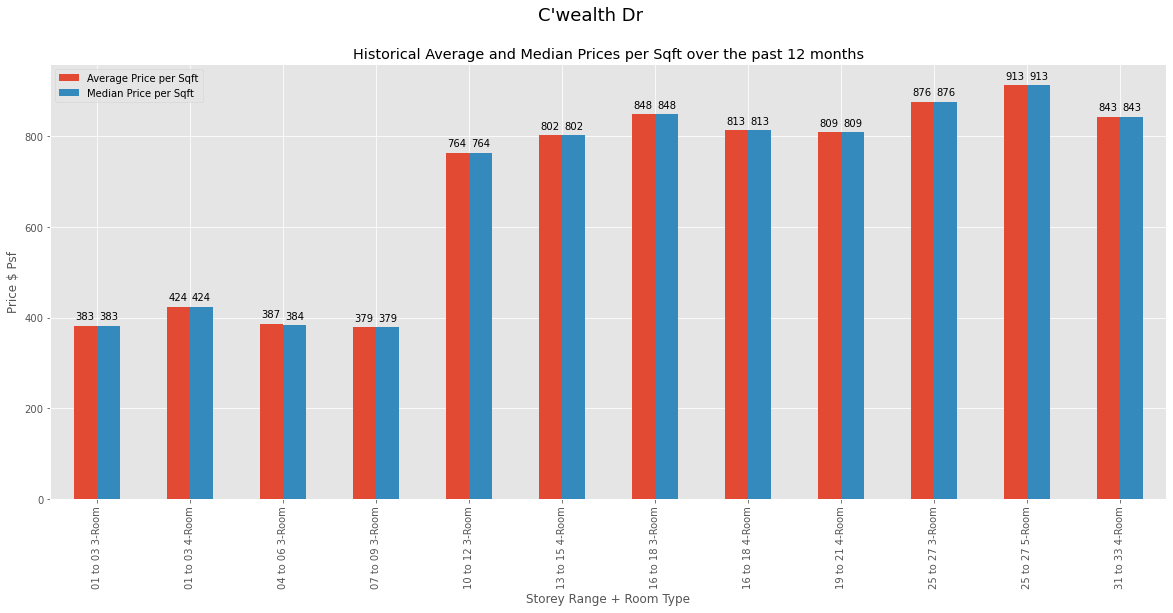

In [25]:
ax = toplot.plot(kind='bar', figsize=(20,8), x = 'Storey Range + Room Type', y=['Average Price per Sqft','Median Price per Sqft'])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0 and height < np.inf:
        ax.annotate(int(round(height)),\
                    (x+width/2, y+height),\
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.suptitle(f"{mystreet}", fontsize=18)
ax.set_ylabel("Price $ Psf", fontsize=12)
ax.set_title(f'Historical Average and Median Prices per Sqft over the past 12 months')
plt.show()

In [26]:
mystreet = 'Tampines Ctrl 8'
tamp = hdb[hdb['Street'].isin([mystreet])]

In [27]:
toplot = tamp.groupby(['Town','Storey','Room Type']).\
agg({'Town':'count', 'Price':['mean','median'], 'Price per Sqm':['mean','median'],\
                                                       'Price per Sqft':['mean','median']}).reset_index()
toplot.columns = ['Town','Storey','Room Type','Total Units','Average Price','Median Price',\
                  'Average Price per Sqm','Median Price per Sqm',\
                  'Average Price per Sqft','Median Price per Sqft']
toplot = toplot.round({'Average Price':2,'Median Price':2,\
                  'Average Price per Sqm':2,'Median Price per Sqm':2,\
                  'Average Price per Sqft':2,'Median Price per Sqft':2})
toplot['Storey Range + Room Type'] = toplot['Storey'] + ' ' + toplot['Room Type']

toplot

,Town,Storey,Room Type,Total Units,Average Price,Median Price,Average Price per Sqm,Median Price per Sqm,Average Price per Sqft,Median Price per Sqft,Storey Range + Room Type
0,Tampines,01 to 03,3-Room,1,445000.00,445000.0,7177.42,7177.42,666.80,666.80,01 to 03 3-Room
1,Tampines,01 to 03,4-Room,1,620000.00,620000.0,7380.95,7380.95,685.71,685.71,01 to 03 4-Room
2,Tampines,04 to 06,3-Room,3,468629.33,470888.0,7558.54,7594.97,702.21,705.59,04 to 06 3-Room
3,Tampines,04 to 06,4-Room,4,617000.00,621500.0,7367.83,7398.81,684.49,687.37,04 to 06 4-Room
4,Tampines,04 to 06,5-Room,1,800000.00,800000.0,7407.41,7407.41,688.16,688.16,04 to 06 5-Room
5,Tampines,07 to 09,3-Room,3,473333.33,480000.0,7719.02,7868.85,717.11,731.03,07 to 09 3-Room
6,Tampines,07 to 09,4-Room,2,629444.00,629444.0,7493.38,7493.38,696.15,696.15,07 to 09 4-Room
7,Tampines,10 to 12,3-Room,4,499222.00,501944.0,8085.35,8095.87,751.15,752.12,10 to 12 3-Room
8,Tampines,10 to 12,4-Room,3,639962.67,636000.0,7618.60,7571.43,707.79,703.40,10 to 12 4-Room
9,Tampines,13 to 15,3-Room,3,497333.33,497000.0,8108.94,8114.75,753.34,753.88,13 to 15 3-Room


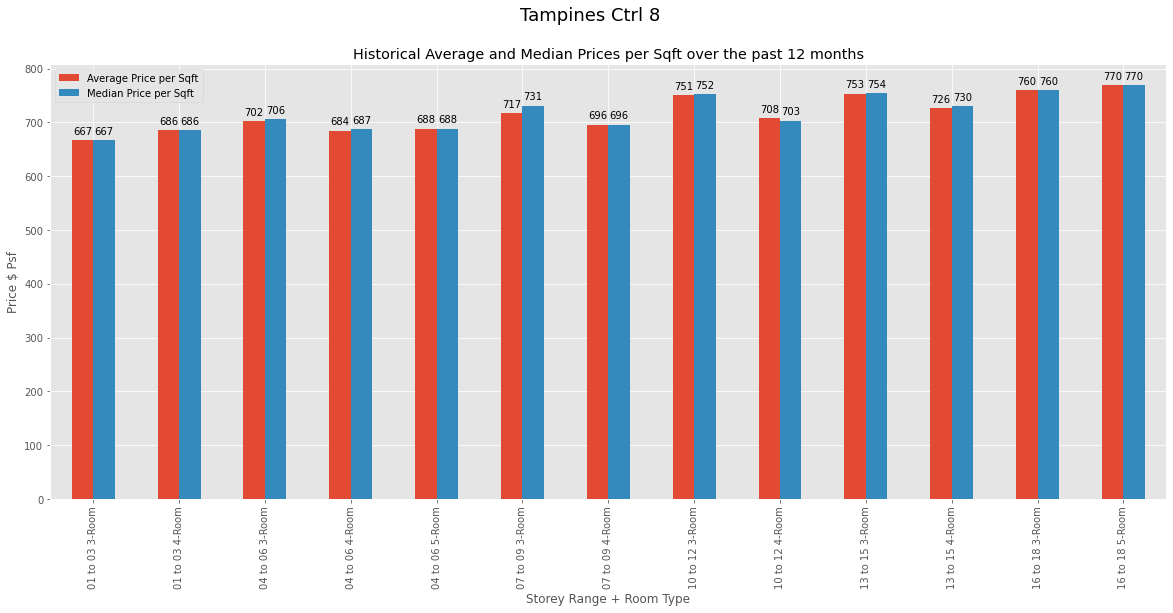

In [28]:
ax = toplot.plot(kind='bar', figsize=(20,8), x = 'Storey Range + Room Type', y=['Average Price per Sqft','Median Price per Sqft'])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0 and height < np.inf:
        ax.annotate(int(round(height)),\
                    (x+width/2, y+height),\
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.suptitle(f"{mystreet}", fontsize=18)
ax.set_ylabel("Price $ Psf", fontsize=12)
ax.set_title(f'Historical Average and Median Prices per Sqft over the past 12 months')
plt.show()

<a id='DBSS'>DBSS</a>

In [30]:
hdb['Type'].unique()

array(['Model', 'Improved', 'Premium', 'Maisonette', 'Apartment', 'Dbss',
       'New', 'Simplified', 'Standard', 'Adjoined', 'Multi', 'Terrace',
       'Type'], dtype=object)

In [31]:
dbss = hdb[hdb['Type']=='Dbss']

In [32]:
toplot = dbss.groupby(['Town','Room Type']).\
agg({'Town':'count', 'Price':['mean','median'], 'Price per Sqm':['mean','median'],\
                                                       'Price per Sqft':['mean','median']}).reset_index()
toplot.columns = ['Town','Room Type','Total Units','Average Price','Median Price',\
                  'Average Price per Sqm','Median Price per Sqm',\
                  'Average Price per Sqft','Median Price per Sqft']
toplot = toplot.round({'Average Price':2,'Median Price':2,\
                  'Average Price per Sqm':2,'Median Price per Sqm':2,\
                  'Average Price per Sqft':2,'Median Price per Sqft':2})
toplot['Town + Room Type'] = toplot['Town'] + ' ' + toplot['Room Type']

toplot

,Town,Room Type,Total Units,Average Price,Median Price,Average Price per Sqm,Median Price per Sqm,Average Price per Sqft,Median Price per Sqft,Town + Room Type
0,Ang Mo Kio,4-Room,7,733428.57,737000.0,8098.76,8133.33,752.39,755.61,Ang Mo Kio 4-Room
1,Ang Mo Kio,5-Room,8,846111.00,842944.0,7513.98,7424.11,698.07,689.72,Ang Mo Kio 5-Room
2,Bedok,3-Room,8,483250.00,486500.0,7294.69,7315.81,677.69,679.66,Bedok 3-Room
3,Bedok,4-Room,14,668214.29,673000.0,7698.34,7735.63,715.19,718.66,Bedok 4-Room
4,Bedok,5-Room,14,804500.00,794000.0,7640.54,7561.90,709.82,702.52,Bedok 5-Room
5,Bishan,4-Room,5,808600.00,815000.0,8511.58,8578.95,790.74,797.00,Bishan 4-Room
6,Bishan,5-Room,9,1008111.11,1050000.0,8400.93,8750.00,780.47,812.89,Bishan 5-Room
7,Clementi,3-Room,12,508833.33,515000.0,8480.56,8583.33,787.86,797.41,Clementi 3-Room
8,Clementi,4-Room,26,751803.38,754500.0,9330.04,9290.40,866.78,863.10,Clementi 4-Room
9,Clementi,5-Room,8,919861.00,912500.0,8760.58,8690.48,813.88,807.36,Clementi 5-Room


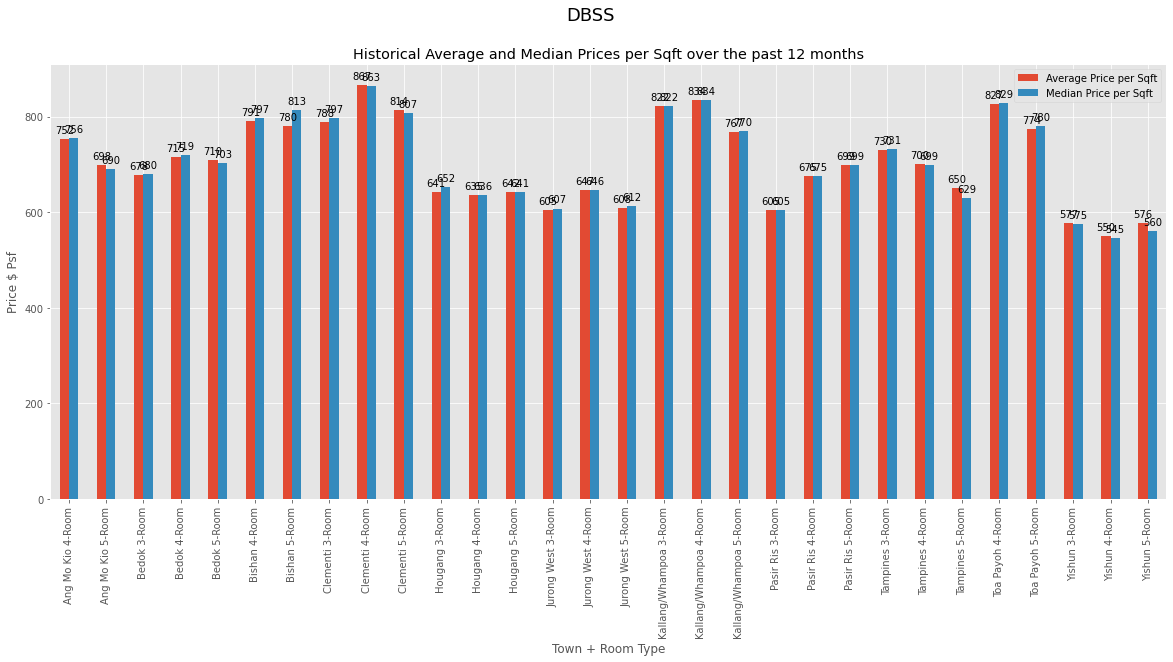

In [33]:
ax = toplot.plot(kind='bar', figsize=(20,8), x = 'Town + Room Type', y=['Average Price per Sqft','Median Price per Sqft'])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0 and height < np.inf:
        ax.annotate(int(round(height)),\
                    (x+width/2, y+height),\
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.suptitle(f"DBSS", fontsize=18)
ax.set_ylabel("Price $ Psf", fontsize=12)
ax.set_title(f'Historical Average and Median Prices per Sqft over the past 12 months')
plt.show()